In [20]:
from brian2 import *

In [21]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [22]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,200000)*dt    # Simulation time array t
num_receptors = 13           # Number of receptor neurons
speed = 80                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for k in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep

Generator spikes:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 11 10  9  8  7  6  5  4  3  2  1
  0  1  2  3  4  5  6  7  8  9 10 11 12 11 10  9]
[  0.   12.6  25.3  37.9  50.6  63.2  75.9  88.6 101.2 113.9 126.5 139.2
 151.8 164.5 177.2 189.8 202.5 215.1 227.8 240.5 253.1 265.8 278.4 291.1
 303.7 316.4 329.1 341.7 354.4 367.  379.7 392.4 405.  417.7 430.3 443.
 455.6 468.3 481.  493.6] ms
Relay spikes:
[10  9  8  7  6  5  4  3  2  1  0 10  9  8]
[165.5 178.6 191.3 204.  216.6 229.3 242.  254.6 267.3 279.9 292.6 469.3
 482.4 495.1] ms
Relay1 spikes:
[ 0  1  2  3  4  5  6  7  8  9 10 11  1  2  3  4  5  6  7  8  9 10 11]
[  1.5  14.1  26.8  39.4  52.1  64.7  77.4  90.1 102.7 115.4 128.  140.7
 317.4 330.5 343.2 355.9 368.5 381.2 393.9 406.5 419.2 431.8 444.5] ms
Output Spikes:
[1 1 1 0 0 1 1]
[ 41.   92.  142.6 205.6 256.4 357.5 408.3] ms


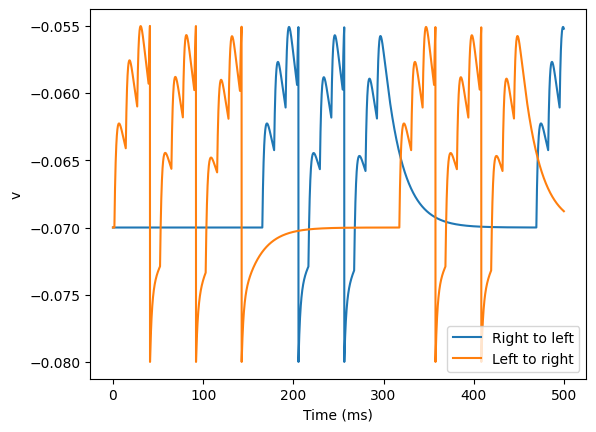

In [23]:
start_scope() 
#spikeArr = [4,3,2,1,0] #Right to left
#spikeArr = [0,1,2,3,4] #Left to right
#timeArr = [10,20,30,40,50]*ms
spikeArr = plot_n
timeArr = plot_t*second

inputSize = num_receptors

generator = SpikeGeneratorGroup(inputSize, spikeArr, timeArr)
generatorMonitor = SpikeMonitor(generator)

tau = 20*ms
tau_syn = 2*ms
I_weight = 3*nA
threshold='v > -55*mV'
v_reset='v = -80*mV'
v_rest = -70*mV
R = 100*Mohm
equ = '''
dv/dt = -(v - v_rest)/tau + R*I_syn/tau : volt
dI_syn/dt = -I_syn/tau_syn : ampere
'''

relay = NeuronGroup(inputSize-1, equ, threshold=threshold, reset=v_reset, method=exact)
relay.v = -70*mV
inpToRel = Synapses(generator, relay, on_pre='I_syn += I_weight')
inpToRel.connect(condition='j+1 == i')
# visualise_connectivity(inpToRel)

relay1 = NeuronGroup(inputSize-1, equ, threshold=threshold, reset=v_reset, method=exact)
relay1.v = -70*mV
inpToRel1 = Synapses(generator, relay1, on_pre='I_syn += I_weight')
inpToRel1.connect(condition='j == i')
# visualise_connectivity(inpToRel1)

inhib = NeuronGroup(inputSize, equ, threshold=threshold, reset=v_reset, method=exact)
inhib.v = -70*mV
inpToIn = Synapses(generator, inhib, on_pre='I_syn += I_weight')
inpToIn.connect(condition='j == i')
# visualise_connectivity(inpToIn)

inToRelay = Synapses(inhib, relay, on_pre='I_syn -= I_weight')
inToRelay.connect(condition='j == i')
# visualise_connectivity(inToRelay)

inToRelay1 = Synapses(inhib, relay1, on_pre='I_syn -= I_weight')
inToRelay1.connect(condition='j+1 == i')
# visualise_connectivity(inToRelay1)

output = NeuronGroup(2, equ, threshold=threshold, reset=v_reset, method=exact)
output.v = -70*mV
relayToOut = Synapses(relay, output, on_pre='I_syn += I_weight/3')
relayToOut.connect(condition='j == 0')
# visualise_connectivity(relayToOut)

relay1ToOut = Synapses(relay1, output, on_pre='I_syn += I_weight/3')
relay1ToOut.connect(condition='j == 1')
# visualise_connectivity(relay1ToOut)

relayMonitor = SpikeMonitor(relay)
relayState = StateMonitor(relay, 'v', record=True)
relay1Monitor = SpikeMonitor(relay1)
relay1State = StateMonitor(relay1, 'v', record=True)
inhibState = StateMonitor(inhib, 'v', record=True)
outputMonitor = SpikeMonitor(output)
outputState = StateMonitor(output, 'v', record=True)

run(500*ms)
print("Generator spikes:")
print(generatorMonitor.i[:])
print(generatorMonitor.t[:])
print("Relay spikes:")
print(relayMonitor.i[:])
print(relayMonitor.t[:])
print("Relay1 spikes:")
print(relay1Monitor.i[:])
print(relay1Monitor.t[:])
print("Output Spikes:")
print(outputMonitor.i[:])
print(outputMonitor.t[:])

plot(outputState.t/ms, outputState.v[0], label='Right to left')
plot(outputState.t/ms, outputState.v[1], label='Left to right')
xlabel('Time (ms)')
ylabel('v')
legend()

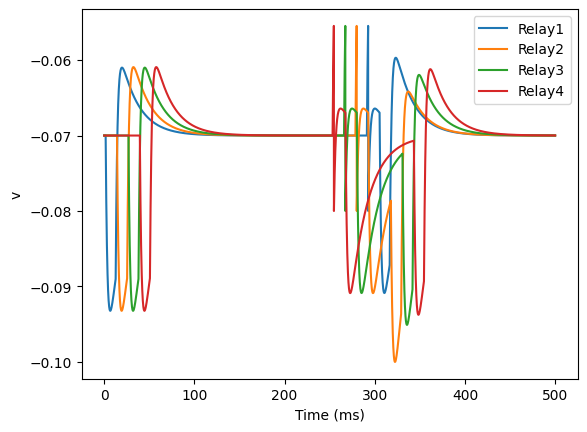

In [24]:
plot(relayState.t/ms, relayState.v[0], label='Relay1')
plot(relayState.t/ms, relayState.v[1], label='Relay2')
plot(relayState.t/ms, relayState.v[2], label='Relay3')
plot(relayState.t/ms, relayState.v[3], label='Relay4')
xlabel('Time (ms)')
ylabel('v')
legend()

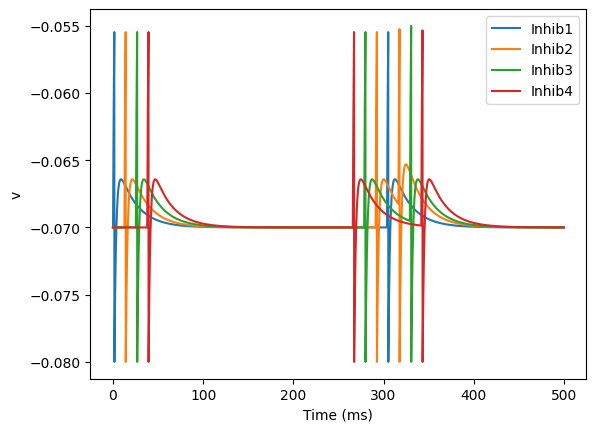

In [25]:
plot(inhibState.t/ms, inhibState.v[0], label='Inhib1')
plot(inhibState.t/ms, inhibState.v[1], label='Inhib2')
plot(inhibState.t/ms, inhibState.v[2], label='Inhib3')
plot(inhibState.t/ms, inhibState.v[3], label='Inhib4')
xlabel('Time (ms)')
ylabel('v')
legend()